In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib,pprint,keras
import random

import FBNN2d,sei_kume,myResNet,FBNN3d
importlib.reload(FBNN2d)
importlib.reload(sei_kume)
importlib.reload(myResNet)
importlib.reload(FBNN3d)
from FBNN2d import *
from sei_kume import *
from myResNet import *
from FBNN3d import *

# 1次元FB分布

### データが少ない場合の予測精度

In [16]:
gene_size=500
model = keras.models.load_model("./models/mymodel_0startN2.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) = gene_data_Normalize(hist_gene,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi,center=np.pi)
    test_data  = [gene_data_one(hist_gene,eig0=0,Sig_lim=20,mu_lim=20,gene_size=100,multi=multi,center=np.pi) for _ in range(10)]
    print(multi,":")

    logL = comp_logL_Sigmu(model,x_test,y_test,mle=False,t0=0,tol=5*1e-3,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)
    
    # print("%d:T-0 diff,mle-0 diff,loss(mse),mae: %f, %f, %f, %f"%(num,logL["T-0"],logL["M-0"],score[0],score[1]))
    print("T-0 diff,loss(mse),mae: %f, %f, %f"%(logL["T-0"],score[0],score[1]))
    # print()

1000000.0 :
T-0 diff,loss(mse),mae: 1.341530, 33.729599, 3.391916
1000.0 :
T-0 diff,loss(mse),mae: 1.335245, 34.868325, 3.439576
100.0 :
T-0 diff,loss(mse),mae: 1.239424, 34.364597, 3.526797
10.0 :
T-0 diff,loss(mse),mae: 1.412679, 45.072087, 4.203482


In [21]:
gene_size=2
mle=True
model = keras.models.load_model("./models/mymodel_0startN2.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) = gene_data_Normalize(hist_gene,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi,center=np.pi)
    test_data  = [gene_data_one(hist_gene,eig0=0,Sig_lim=20,mu_lim=20,gene_size=100,multi=multi,center=np.pi) for _ in range(10)]
    print(multi,":")

    logL = comp_logL_Sigmu(model,x_test,y_test,mle=mle,t0=0,tol=5*1e-3,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)
    
    print("%d:T-0 diff,mle-0 diff,loss(mse),mae: %f, %f, %f, %f"%(num,logL["T-0"],logL["M-0"],score[0],score[1]))
    # print("T-0 diff,loss(mse),mae: %f, %f, %f"%(logL["T-0"],score[0],score[1]))
    # print()

1000000.0 :
7:T-0 diff,mle-0 diff,loss(mse),mae: 1.327840, 0.237579, 33.843959, 3.396827
1000.0 :
7:T-0 diff,mle-0 diff,loss(mse),mae: 2.377635, 0.098686, 34.463114, 3.478993
100.0 :
7:T-0 diff,mle-0 diff,loss(mse),mae: 0.462975, 0.127571, 35.982188, 3.602466
10.0 :
7:T-0 diff,mle-0 diff,loss(mse),mae: 0.852305, 0.361638, 44.930309, 4.209011


### ノイズありデータにおける予測精度

1. 固有値の内の一つを0に固定したモデル

In [17]:
t0=0
# gene_size=500
gene_size=2
model = keras.models.load_model("./models/mymodel_0startN2.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) = gene_data_Normalize(hist_gene_noise,gene_size=gene_size,multi=multi,center=np.pi,Sig_lim=20,mu_lim=20)
    test_data  = [gene_data_one(hist_gene_noise,eig0=t0*2,gene_size=100,      multi=multi,center=np.pi,Sig_lim=20,mu_lim=20) for _ in range(10)]
    print(multi,":")
    logL = comp_logL_Sigmu(model,x_test,y_test,mle=True,t0=t0,tol=5*1e-2,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)

    print("T-0 logL, mle-0 logL: %f, %f"%(logL["T-0"],logL["M-0"]) )
    print("Test loss, Test mae, mean iters: %f, %f, %3d" % (score[0], score[1], logL["iters"]))
    print()

1000000.0 :
T-0 logL, mle-0 logL: 0.663653, 0.498819
Test loss, Test mae, mean iters: 33.279836, 3.383015,  51

1000.0 :
T-0 logL, mle-0 logL: 0.546307, 0.490611
Test loss, Test mae, mean iters: 34.861257, 3.453292, 100

100.0 :
T-0 logL, mle-0 logL: 7.219554, 1.298013
Test loss, Test mae, mean iters: 37.248091, 3.717604, 100

10.0 :
T-0 logL, mle-0 logL: 35.160685, 27.029820
Test loss, Test mae, mean iters: 43.422865, 4.259510,  92



2. 固有値を一つ2に固定したモデル

In [20]:
t0=1
# gene_size=500
gene_size=2
model = keras.models.load_model("./models/mymodel_1start4.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) = gene_data_Normalize(hist_gene_noise,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi,center=np.pi)
    test_data  = [gene_data_one(hist_gene,eig0=t0*2,Sig_lim=20,mu_lim=20,gene_size=100,multi=multi,center=np.pi) for _ in range(10)]
    print(multi,":")
    logL = comp_logL_Sigmu(model,x_test,y_test,mle=True,t0=t0,tol=5*1e-2,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)

    print("T-0 logL, mle-0 logL: %f, %f"%(logL["T-0"],logL["M-0"]) )
    print("Test loss, Test mae, mean iters: %f, %f, %3d" % (score[0], score[1], logL["iters"]))
    print()

1000000.0 :
T-0 logL, mle-0 logL: 2.701932, 0.657393
Test loss, Test mae, mean iters: 20.396717, 3.192838, 100

1000.0 :
T-0 logL, mle-0 logL: 2.152800, 0.121902
Test loss, Test mae, mean iters: 19.198305, 3.071372,  56

100.0 :
T-0 logL, mle-0 logL: 1.635154, 0.920024
Test loss, Test mae, mean iters: 20.538620, 3.203044,  63

10.0 :
T-0 logL, mle-0 logL: 35.653683, 12.421934
Test loss, Test mae, mean iters: 23.892201, 3.512517,  72



### 学習時からノイズを混ぜる

noise+LReLU
1000:mean diff:1.475166 ;Test loss, Test mae: 33.418401, 3.488010
100:mean diff:3.320806 ;Test loss, Test mae: 34.173045, 3.553953
 10:mean diff:27.898245 ;Test loss, Test mae: 50.104672, 4.681037
noise+ReLU+Resnet


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000:mean diff:1.548478 ;Test loss, Test mae: 33.479061, 3.465138
100:mean diff:4.411475 ;Test loss, Test mae: 37.540167, 3.757531
 10:mean diff:45.864405 ;Test loss, Test mae: 90.019907, 7.042224


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


noise+LReLU+Resnet
1000:mean diff:3.018412 ;Test loss, Test mae: 35.335198, 3.554582
100:mean diff:5.854616 ;Test loss, Test mae: 37.588289, 3.733643
 10:mean diff:55.187115 ;Test loss, Test mae: 101.665092, 7.365968


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


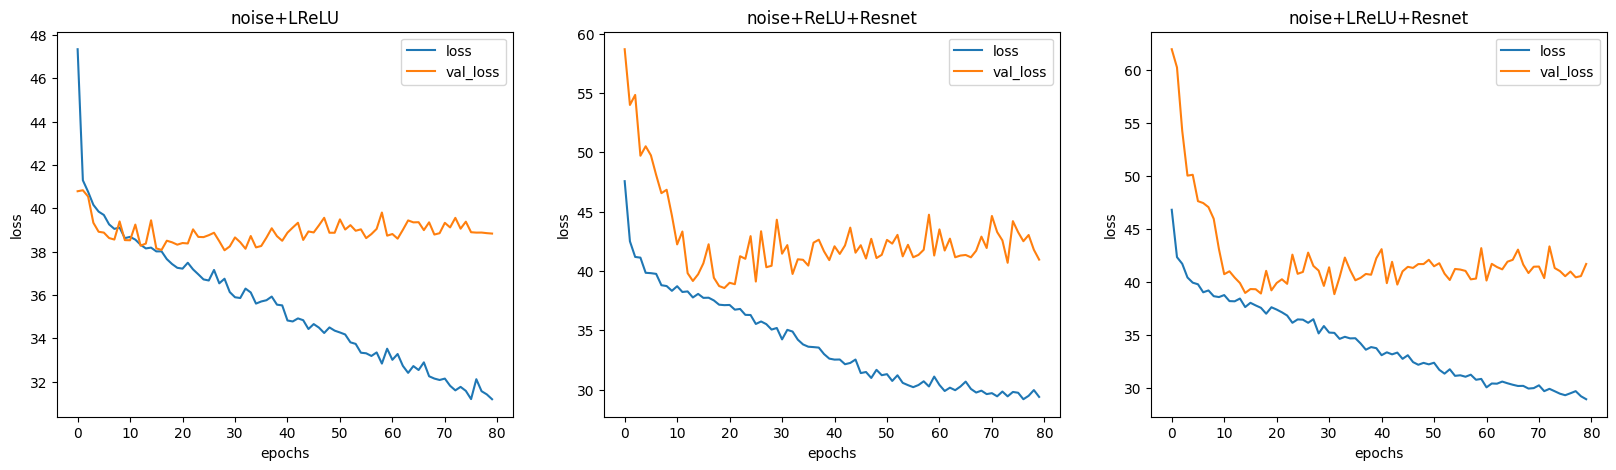

In [38]:
# gd_f = gene_data_zero_thga3
# hg_f = hist_gene_thga
# hg_noise_f = hist_gene_thga_noise

gd_f = gene_data_zero
hg_f = hist_gene
hg_noise_f = hist_gene_noise

(x_train0,y_train0) = gd_f(hg_f,Sig_lim=20,mu_lim=20,gene_size=2000,multi=-1) #1e6
(x_train1,y_train1) = gd_f(hg_noise_f,Sig_lim=20,mu_lim=20,gene_size=200,multi=-1)
(x_train2,y_train2) = gd_f(hg_noise_f,Sig_lim=20,mu_lim=20,gene_size=20,multi=-1)
# print(type(x_train))
x_train=list(x_train1)+list(x_train0)+list(x_train2)
y_train=list(y_train1)+list(y_train0)+list(y_train2)

mul=[1e3,1e2,1e1]
tds = [[gd_f(hg_noise_f,Sig_lim=20,mu_lim=20,gene_size=20,multi=multi) for _ in range(10)] for multi in mul]

models=[]
models.append(set_model_zero_LeakyReLU(output_shape=5,n_hidden=400,n_layer=5,print_summary=False,leaky_alpha=0.01))
models.append(build((20,), 5, 400,hidden_layer=18))
models.append(build((20,), 5, 400,hidden_layer=18,leakyReLU=True,leaky_alpha=0.01))

titles=["noise+LReLU","noise+ReLU+Resnet","noise+LReLU+Resnet"]
fig, axes = plt.subplots(ncols=len(models), figsize=(20, 5))
for i,model in enumerate(models):
    print(titles[i])
    model.compile(loss='mse',
                    optimizer='adam',
                    # optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                    metrics=['mae'])

    history = model.fit(np.array(x_train), np.array(y_train), verbose=0,
                        epochs=80, validation_split=0.2, shuffle=True
                        # epochs=80, batch_size=30,validation_data=(x_test, y_test)
                        )

    for j,test_data in enumerate(tds):
        scores=[model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
        score = np.mean(scores,axis=0)

        res_mean = np.mean([comp_logL_Sigmu(model,x_test,y_test)["T-0"] for (x_test, y_test) in test_data])
        # print("Test loss, Test mae: %f, %f" % (score[0], score[1]))
        print("%4d:mean diff:%f ;Test loss, Test mae: %f, %f" % (mul[j], res_mean, score[0], score[1]))
    model.save("./models/mymodel_0start%d.h5"%(i+8), include_optimizer=False)
    print()

    df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    df.plot(ax=axes[i],xlabel="epochs",ylabel="loss",title=titles[i])
plt.show()

# 2次元FB分布

### データが少ない場合の予測精度

In [25]:
gene_size=500
model = keras.models.load_model("./models/mymodel_3d4.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) =    gene_data_3d(normalize=True,gene_size=gene_size,multi=multi,Sig_lim=20,mu_lim=20)
    test_data  = [gene_data_3d(eig0=2,normalize=True,gene_size=100,      multi=multi,Sig_lim=20,mu_lim=20) for _ in range(10)]
    print(multi,":")

    logL = comp_logL_Sigmu_3d(model,x_test,y_test,mle=False,t0=1,tol=5*1e-3,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)
    
    # print("%d:T-0 diff,mle-0 diff,loss(mse),mae: %f, %f, %f, %f"%(num,logL["T-0"],logL["M-0"],score[0],score[1]))
    print("T-0 diff,loss(mse),mae: %f, %f, %f"%(logL["T-0"],score[0],score[1]))

1000000.0 :
T-0 diff,loss(mse),mae: 2.395195, 22.103454, 3.421220
1000.0 :
T-0 diff,loss(mse),mae: 2.642631, 21.375985, 3.393257
100.0 :
T-0 diff,loss(mse),mae: 2.730819, 21.584805, 3.414395
10.0 :
T-0 diff,loss(mse),mae: 3.048959, 22.465899, 3.476197


In [38]:
gene_size=1
model = keras.models.load_model("./models/mymodel_3d4.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) =    gene_data_3d(normalize=True,gene_size=gene_size,multi=multi,Sig_lim=20,mu_lim=20)
    test_data  = [gene_data_3d(eig0=2,normalize=True,gene_size=100,      multi=multi,Sig_lim=20,mu_lim=20) for _ in range(10)]
    print(multi,":")

    logL = comp_logL_Sigmu_3d(model,x_test,y_test,mle=True,t0=1,tol=5*1e-3,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)
    
    print("%d:T-0 diff,mle-0 diff,loss(mse),mae: %f, %f, %f, %f"%(num,logL["T-0"],logL["M-0"],score[0],score[1]))
    # print("T-0 diff,loss(mse),mae: %f, %f, %f"%(logL["T-0"],score[0],score[1]))

1000000.0 :


KeyboardInterrupt: 

### ノイズありデータにおける予測精度

In [32]:
t0=1
gene_size=2
model = keras.models.load_model("./models/mymodel_3d4.h5", compile=False)
model.compile(loss='mse',optimizer='adam',metrics=['mae'])

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,y_test) =       gene_data_3d(noise=True,gene_size=gene_size,multi=multi,normalize=True,Sig_lim=20,mu_lim=20)
    test_data  = [gene_data_3d(eig0=t0*2,noise=True,gene_size=100,      multi=multi,normalize=True,Sig_lim=20,mu_lim=20) for _ in range(10)]
    print(multi,":")
    logL = comp_logL_Sigmu_3d(model,x_test,y_test,mle=True,t0=t0,tol=5*1e-2,iterss=100,method="hg")

    scores=[model.evaluate(x_test0, y_test0, verbose=0) for (x_test0, y_test0) in test_data]
    score = np.mean(scores,axis=0)

    print("T-0 logL, mle-0 logL: %f, %f"%(logL["T-0"],logL["M-0"]) )
    print("Test loss, Test mae, mean iters: %f, %f, %3d" % (score[0], score[1], logL["iters"]))
    print()

1000000.0 :
T-0 logL, mle-0 logL: 2.749253, 2.842243
Test loss, Test mae, mean iters: 21.379560, 3.389719,  51

1000.0 :
T-0 logL, mle-0 logL: 2.751583, 4.337521
Test loss, Test mae, mean iters: 20.604824, 3.352810, 100

100.0 :
T-0 logL, mle-0 logL: 4.509977, 10.121499
Test loss, Test mae, mean iters: 21.691495, 3.411748, 100

10.0 :
T-0 logL, mle-0 logL: 207.711897, 12.266596
Test loss, Test mae, mean iters: 36.574677, 4.336940, 100



## 学習時からnoiseをまぜたもの

1000000.0
T-0 diff,mle-0 diff,loss(mse),mae: 0.908273, 0.417858, 22.202833, 3.421063
1000.0
T-0 diff,mle-0 diff,loss(mse),mae: 1.727075, 0.785784, 24.755732, 3.509041
100.0
T-0 diff,mle-0 diff,loss(mse),mae: 35.251418, 5.502825, 26.047032, 3.730700
10.0
T-0 diff,mle-0 diff,loss(mse),mae: 53.122815, 20.148644, 61.043082, 5.609354


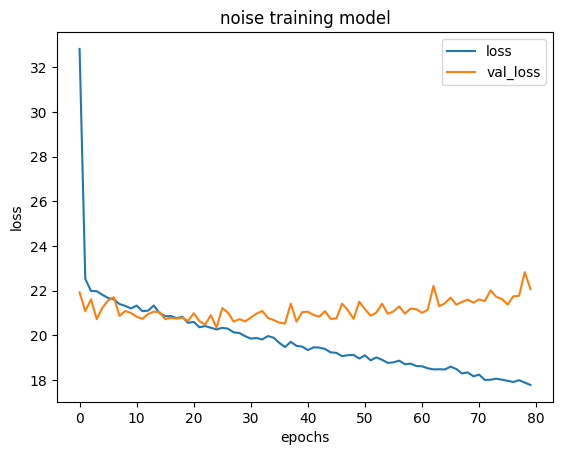

In [42]:
(x_train0,y_train0) = gene_data_3d(           gene_size=2000,normalize=True,eig0=2,multi=1e6,Sig_lim=20,mu_lim=20) #1e6
(x_train1,y_train1) = gene_data_3d(noise=True,gene_size=200, normalize=True,eig0=2,multi=1e6,Sig_lim=20,mu_lim=20)
(x_train2,y_train2) = gene_data_3d(noise=True,gene_size=20,  normalize=True,eig0=2,multi=1e6,Sig_lim=20,mu_lim=20)
# print(type(x_train))
x_train = np.array(list(x_train1)+list(x_train0)+list(x_train2))
y_train = np.array(list(y_train1)+list(y_train0)+list(y_train2))

mul=[1e6,1e3,1e2,1e1]
model = set_model_3d(n_hidden=1100,n_layer=5,print_summary=False)
history = model.fit(x_train, y_train, verbose=0, epochs=80, shuffle=True, validation_split=0.2)
for multi in mul:
    print(multi)
    test_data = [gene_data_3d(noise=True,gene_size=50,normalize=True,eig0=2,multi=multi,Sig_lim=20,mu_lim=20) for _ in range(10)]
    scores = [model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
    score  = np.mean(scores,axis=0)
    (x_test,y_test) = gene_data_3d(noise=True,gene_size=2,normalize=True,multi=multi,Sig_lim=20,mu_lim=20)
    logL = comp_logL_Sigmu_3d(model,x_test,y_test,mle=True,t0=1,tol=5*1e-2,iterss=100,method="hg")
    print("T-0 diff,mle-0 diff,loss(mse),mae: %f, %f, %f, %f"%(logL["T-0"],logL["M-0"],score[0],score[1]))

fig, axes = plt.subplots()
df = pd.DataFrame(history.history)[['loss', 'val_loss']]
df.plot(ax=axes,xlabel="epochs",ylabel="loss",title="noise training model")
plt.show()